In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [5]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )

In [6]:
data_DMA225 = data[['Date_time','DMA_225']]

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

In [8]:
# Sampling the data into daily sum.
dd = data_DMA225_indexed.resample('D').sum()
dd.shape

(365, 1)

In [9]:
dd

,DMA_225
Date_time,
2016-04-01,354.219001
2016-04-02,313.328000
2016-04-03,303.778001
2016-04-04,310.109000
2016-04-05,294.445000
...,...
2017-03-27,212.222000
2017-03-28,177.217999
2017-03-29,177.221000


In [10]:

# Split train data and test data
train_size = int(len(dd)*0.7)

#train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dd.iloc[:train_size]
test_data = dd.iloc[train_size:]

In [11]:
train_data.shape

(255, 1)

In [12]:
test_data.shape

(110, 1)

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)


# Multistep time series forecasting

Here look_back or timesteps = 14 and so the model makes predictions based on the last 14-day data (the input carries the first 14 days, in the first iteration of the for-loop, and the output is water demand on the 14th day).

In [14]:
def matrix_dataset(array_dataset, timesteps=1):
 mat_X, mat_Y = [], []
 for i in range(len(array_dataset)-timesteps-1):
  Z = i+timesteps
  m = array_dataset[i:Z, 0]
  mat_X.append(m)
  n = array_dataset[Z, 0]
  mat_Y.append(n)
 return np.array(mat_X), np.array( mat_Y)


look_back = 14
features = 1
X_train1, Y_train1 = matrix_dataset(train_scaled, look_back)
X_test1, Y_test1 = matrix_dataset(test_scaled, look_back)

In [15]:
X_train1.shape

(240, 14)

In [16]:
X_train1 = X_train1.reshape((X_train1.shape[0],X_train1.shape[1],1))
X_test1 = X_test1.reshape( (X_test1.shape[0],X_test1.shape[1],1))

In [17]:
X_train1.shape

(240, 14, 1)

In [18]:
X_test1.shape

(95, 14, 1)

In [30]:

model = tf.keras.Sequential()
model.add(LSTM(40, activation = 'relu',input_shape=(look_back,features)))
model.add(Dropout(0.9))
model.add(Dense(14))
model.compile(loss='mean_squared_error', optimizer='adam')
#history=model.fit(X_train1, Y_train1, validation_data=(X_test1,Y_test1),shuffle=False, epochs=100, batch_size=1, verbose=2)
history=model.fit(X_train1,Y_train1,validation_data=(X_test1,Y_test1),epochs=100,batch_size=1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=2, shuffle=False)

Epoch 1/100
240/240 - 2s - loss: 0.0144 - val_loss: 0.0131
Epoch 2/100
240/240 - 1s - loss: 0.0143 - val_loss: 0.0132
Epoch 3/100
240/240 - 1s - loss: 0.0133 - val_loss: 0.0135
Epoch 4/100
240/240 - 1s - loss: 0.0135 - val_loss: 0.0131
Epoch 5/100
240/240 - 1s - loss: 0.0134 - val_loss: 0.0131
Epoch 6/100
240/240 - 1s - loss: 0.0133 - val_loss: 0.0125
Epoch 7/100
240/240 - 1s - loss: 0.0136 - val_loss: 0.0126
Epoch 8/100
240/240 - 1s - loss: 0.0125 - val_loss: 0.0123
Epoch 9/100
240/240 - 1s - loss: 0.0132 - val_loss: 0.0127
Epoch 10/100
240/240 - 1s - loss: 0.0130 - val_loss: 0.0126
Epoch 11/100
240/240 - 1s - loss: 0.0125 - val_loss: 0.0119
Epoch 12/100
240/240 - 1s - loss: 0.0116 - val_loss: 0.0118
Epoch 13/100
240/240 - 1s - loss: 0.0121 - val_loss: 0.0118
Epoch 14/100
240/240 - 1s - loss: 0.0123 - val_loss: 0.0119
Epoch 15/100
240/240 - 1s - loss: 0.0114 - val_loss: 0.0115
Epoch 16/100
240/240 - 1s - loss: 0.0139 - val_loss: 0.0121
Epoch 17/100
240/240 - 1s - loss: 0.0111 - val_lo

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40)                6720      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 14)                574       
Total params: 7,294
Trainable params: 7,294
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Generate predictions
train_pred = model.predict(X_train1)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(X_test1)

In [32]:
# De-standardising the output to original value
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([Y_train1])
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([Y_test1])
predictions = test_pred

In [33]:
y_test.shape

(1, 95)

In [34]:
predictions.shape

(95, 14)

In [35]:
test_pred.shape

(95, 14)

In [36]:
import math
from sklearn.metrics import mean_squared_error
#trainset = math.sqrt(mean_squared_error(y_train[0],train_pred[:,0]))
testset = math.sqrt(mean_squared_error(y_test[0],test_pred[:,0]))

#print("The RMSE prediction value on trainset: ",trainset)
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  105.39379161706434


In [37]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

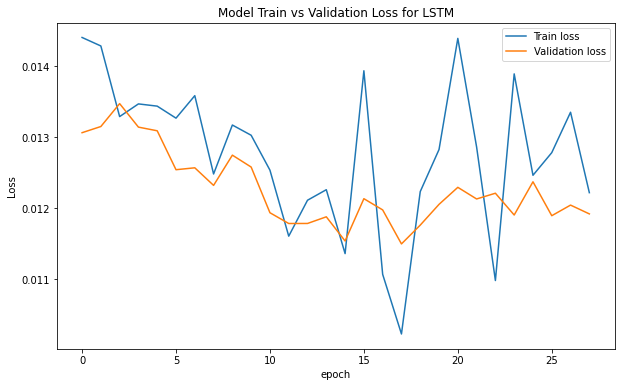

In [38]:
plot_loss(history,'LSTM')